In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 28.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 116 kB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=6, hidden_size=10, batch_first=True)

    def forward(self, x):
        x, _ = self.lstm(x)
        return x[:,-1,:] #using last timestamp of lstm


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
with open('/content/drive/MyDrive/uci/walking_labels.npz','rb') as f:
  labels = np.load(f)['arr_0']
train_mask = labels<=20

In [42]:
class myDataset(torch.utils.data.Dataset):
  def __init__(self, features, labels):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.features = torch.from_numpy(features).to(torch.float32)
        self.labels = torch.from_numpy(labels).to(torch.float32)

  def __len__(self):
      return self.labels.shape[0]

  def __getitem__(self, idx):
      return self.features[idx], self.labels[idx]


device = torch.device("cuda")

batch_size = 16



In [43]:
features = np.load('/content/drive/MyDrive/uci/walking_data.npz')['arr_0']
print(features.shape)
train_l = labels[train_mask]
train_f = features[train_mask]
test_l = labels[np.logical_not(train_mask)]
test_f = features[np.logical_not(train_mask)]

(355, 120, 6)


In [44]:
dataset1 = myDataset(train_f, train_l)
dataset2 = myDataset(test_f, test_l)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

In [45]:
b = dataset1[0]
print(type(b[0]))

<class 'torch.Tensor'>


In [46]:
### pytorch-metric-learning stuff ###
distance = distances.LpDistance()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###


for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.12602032721042633, Number of mined triplets = 76


100%|██████████| 4/4 [00:00<00:00, 12.92it/s]


Computing accuracy


Test set accuracy (Precision@1) = 0
Epoch 2 Iteration 0: Loss = 0.10922641307115555, Number of mined triplets = 36


100%|██████████| 4/4 [00:00<00:00, 10.63it/s]


Computing accuracy


Test set accuracy (Precision@1) = 0
Epoch 3 Iteration 0: Loss = 0.09356894344091415, Number of mined triplets = 11


100%|██████████| 4/4 [00:00<00:00,  9.39it/s]


Computing accuracy


Test set accuracy (Precision@1) = 0
Epoch 4 Iteration 0: Loss = 0.10889728367328644, Number of mined triplets = 27


100%|██████████| 4/4 [00:00<00:00, 18.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0
Epoch 5 Iteration 0: Loss = 0.12977105379104614, Number of mined triplets = 21


100%|██████████| 4/4 [00:00<00:00, 30.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0
Epoch 6 Iteration 0: Loss = 0.10284841805696487, Number of mined triplets = 33


100%|██████████| 4/4 [00:00<00:00, 30.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0
Epoch 7 Iteration 0: Loss = 0.08542612940073013, Number of mined triplets = 13


100%|██████████| 4/4 [00:00<00:00, 27.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0
Epoch 8 Iteration 0: Loss = 0.1342879831790924, Number of mined triplets = 19


100%|██████████| 4/4 [00:00<00:00, 31.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0
Epoch 9 Iteration 0: Loss = 0.056273121386766434, Number of mined triplets = 13


100%|██████████| 4/4 [00:00<00:00, 28.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0
Epoch 10 Iteration 0: Loss = 0.10757243633270264, Number of mined triplets = 20


100%|██████████| 4/4 [00:00<00:00, 30.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0


In [51]:
from sklearn.metrics import top_k_accuracy_score

model.eval()
def eval_emb():
  y_pred = []
  y_true = []
  for i in range(test_l.shape[0]):
    trial = []
    for j in range(10):
      cl=j+21
      cl_samples = test_f[test_l==cl]
      trial.append(cl_samples[np.random.choice(cl_samples.shape[0])])
    x = test_f[i]
    # trial = np.concatenate(trial, axis=0)
    trial = np.stack(trial)
    # print(trial.shape)
    # print(x.shape)
    trial = np.concatenate((trial, x[None,:]), axis=0)
    with torch.no_grad():
      embed = model(torch.tensor(trial).float().to(device))
      embed = embed.cpu().numpy()
      # print(embed.shape)
    trial = embed[:-1,:]
    x = embed[-1,:]
    # print('trual shape is',trial.shape)
    scores = -np.mean((trial - x)**2, axis=-1)
    # print('scores shape is',scores.shape)
    y_pred.append(scores)
    y_true.append(test_l[i])
  y_true = np.asarray(y_true)
  y_pred = np.vstack(y_pred)
  # print('y_pred shape', y_pred.shape)
  # print('y_true shape', y_true.shape)
  t1 = top_k_accuracy_score(y_true, y_pred,k=1, labels = list(range(21,31)), normalize=True)
  t3 = top_k_accuracy_score(y_true, y_pred,k=3, labels = list(range(21,31)), normalize=True)
  t5 = top_k_accuracy_score(y_true, y_pred,k=5, labels = list(range(21,31)), normalize=True)
  print('top 1 accuracy is',t1)
  print('top 3 accuracy is', t3)
  print('top 5 accuracy is', t5)
  # print(y_pred)
  # print(y_true)

eval_emb()

top 1 accuracy is 0.41025641025641024
top 3 accuracy is 0.7008547008547008
top 5 accuracy is 0.8547008547008547


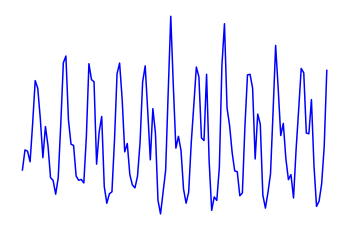

In [54]:
import matplotlib.pyplot as plt

plt.plot(train_f[0,:,0], 'b-', label='data')
plt.axis('off')
plt.show()